# Sentiment Analyse von diversen Reviewdaten durch die Nutzung von Wordembeddings und LSTM

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers


2023-07-03 02:28:39.692153: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 02:28:39.717758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 02:28:40.101928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%pip install kaggle

/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Note: you may need to restart the kernel to use updated packages.


# Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
!unzip mcdonalds-store-reviews.zip

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
100%|██████████████████████████████████████| 25.7M/25.7M [00:04<00:00, 7.17MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:04<00:00, 6.07MB/s]
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [4]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')
df_mc = df_mc[df_mc['rating'] != '3 stars']
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()
rating_mapping_imdb = {
    'positive': 1,
    'negative': 0,
}

label_imdb = df_imdb['sentiment'].map(rating_mapping_imdb).to_numpy()
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb,label_mc)

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

In [6]:
max_length = 600
max_tokens = 20000
text_vectorization_sequence = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization_sequence.adapt(train_data)
text_vectorization_sequence.adapt(test_data)

int_train_ds = text_vectorization_sequence(train_data)

int_test_ds = text_vectorization_sequence(test_data)

vocabulary = np.array(text_vectorization_sequence.get_vocabulary())

print("Vocabulary size: {}".format(len(vocabulary)))
print("Vocabulary content:\n {}".format(vocabulary[:20]))

Vocabulary size: 20000
Vocabulary content:
 ['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'i' 'it' 'this' 'that'
 'br' 'was' 'for' 'as' 'with' 'but' 'movie']


One hot encode Versuch

In [7]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
___________________________________________________

2023-07-03 01:47:03.113914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 01:47:03.114679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 01:47:03.115185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [8]:
callbacks = [
  keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]

oh_history = model.fit(int_train_ds, train_label, epochs=10,validation_split=0.2,callbacks=callbacks)

model.evaluate(int_test_ds)

Epoch 1/10


2023-07-03 01:47:23.143445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 01:47:23.144318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 01:47:23.144845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1571/1572 [============================>.] - ETA: 0s - loss: 0.4539 - accuracy: 0.7952

2023-07-03 01:49:07.296684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 01:49:07.297568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 01:49:07.298055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1572/1572 [==============================] - 119s 75ms/step - loss: 0.4538 - accuracy: 0.7952 - val_loss: 0.3151 - val_accuracy: 0.8746
Epoch 2/10
1572/1572 [==============================] - 116s 74ms/step - loss: 0.3049 - accuracy: 0.8852 - val_loss: 0.2883 - val_accuracy: 0.8843
Epoch 3/10
1572/1572 [==============================] - 116s 74ms/step - loss: 0.2677 - accuracy: 0.8999 - val_loss: 0.3669 - val_accuracy: 0.8712
Epoch 4/10
1572/1572 [==============================] - 114s 73ms/step - loss: 0.2425 - accuracy: 0.9115 - val_loss: 0.2703 - val_accuracy: 0.8959
Epoch 5/10
1572/1572 [==============================] - 115s 73ms/step - loss: 0.2265 - accuracy: 0.9184 - val_loss: 0.2686 - val_accuracy: 0.8955
Epoch 6/10
1572/1572 [==============================] - 117s 75ms/step - loss: 0.2149 - accuracy: 0.9234 - val_loss: 0.4090 - val_accuracy: 0.8457
Epoch 7/10
1572/1572 [==============================] - 116s 74ms/step - loss: 0.2022 - accuracy: 0.9292 - val_loss: 0.3329 - val

OSError: No file or directory found at one_hot_bidir_lstm.keras

Word-Embedding Ansatz

In [10]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model.summary()

2023-06-27 19:24:36.533207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 19:24:36.534950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 19:24:36.537415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

2023-06-27 19:24:36.799338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 19:24:36.801435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 19:24:36.803011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
callbacks = [
  keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]
model.fit(int_train_ds, train_label,validation_split=0.4
, epochs=10,
 callbacks=callbacks)

Epoch 1/10


1965/1965 [==============================] - 642s 327ms/step - loss: 0.4021 - accuracy: 0.8283
Epoch 2/10
1965/1965 [==============================] - 640s 326ms/step - loss: 0.2919 - accuracy: 0.8870
Epoch 3/10
 718/1965 [=========>....................] - ETA: 6:06 - loss: 0.2498 - accuracy: 0.9085

In [ ]:
model.evaluate(int_test_ds, test_label)

## Nutzen von vordefinierten Embeddings
Nun nutzen wir die [GloVe](https://github.com/stanfordnlp/GloVe) embeddings von der Stanford NLP Arbeitsgruppe.
Es wird das 100d Model genutzt welches auf Kaggle ([hier](https://www.kaggle.com/datasets/anindya2906/glove6b)) heruntergeladen werden kann. Anschliessend muss dieses in den `embeddings` ordner gelegt werden, sodass `embeddings/glove.6B.100d.txt` zur Verfuegung steht.

In [8]:
from utils.file_utils import read_embeddings
filepath = './embeddings/glove.6B.100d.txt'
GLOVE_EMBEDDINGS = read_embeddings(filepath)

Wir koennen uns einige Vektoren anschauen.

In [9]:
test_word = 'hello'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f"Vektor des Wortes '{test_word}' sieht wie folgt aus:\n\n{test_vector}")

Vektor des Wortes 'hello' sieht wie folgt aus:

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.273

Ebenfalls koennen wir sehen, dass alle Vektoren 100 Dimensionen haben.

In [10]:
print(f"Vector shape: {test_vector.shape}")

Vector shape: (100,)


Encodieren unseres Vokabulares mit GloVe Vektoren.

In [14]:
embedding_dim = 100
EMBEDDINGS_MATRIX = np.zeros((max_tokens, embedding_dim))

for i, word in np.ndenumerate(vocabulary):
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [15]:
def create_model(vocab_size, embedding_dim, maxlen, embedding_matrix):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.5)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=5,
        restore_best_weights=True)
    
    callbacks = [early_stopping]    

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model, callbacks

In [16]:
model, callbacks = create_model(max_tokens, embedding_dim, max_length, EMBEDDINGS_MATRIX)

2023-07-03 02:36:43.399822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 02:36:43.400683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 02:36:43.401196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
history = model.fit(int_train_ds, train_label, validation_split=0.2, epochs=10, callbacks=callbacks)

Epoch 1/10


2023-07-03 02:37:58.017239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 02:37:58.018185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 02:37:58.018723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1572/1572 [==============================] - ETA: 0s - loss: 0.5371 - accuracy: 0.7281

2023-07-03 02:38:48.375920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 02:38:48.376578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 02:38:48.377084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1572/1572 [==============================] - 56s 34ms/step - loss: 0.5371 - accuracy: 0.7281 - val_loss: 0.4386 - val_accuracy: 0.7910
Epoch 2/10
1572/1572 [==============================] - 55s 35ms/step - loss: 0.4375 - accuracy: 0.7992 - val_loss: 0.3732 - val_accuracy: 0.8416
Epoch 3/10
1572/1572 [==============================] - 54s 34ms/step - loss: 0.4032 - accuracy: 0.8200 - val_loss: 0.4367 - val_accuracy: 0.8030
Epoch 4/10
1572/1572 [==============================] - 53s 34ms/step - loss: 0.3789 - accuracy: 0.8315 - val_loss: 0.3277 - val_accuracy: 0.8598
Epoch 5/10
1572/1572 [==============================] - 56s 35ms/step - loss: 0.3665 - accuracy: 0.8399 - val_loss: 0.2971 - val_accuracy: 0.8768
Epoch 6/10
1572/1572 [==============================] - 56s 36ms/step - loss: 0.3599 - accuracy: 0.8442 - val_loss: 0.2934 - val_accuracy: 0.8744
Epoch 7/10
1572/1572 [==============================] - 55s 35ms/step - loss: 0.3532 - accuracy: 0.8481 - val_loss: 0.2974 - val_accura

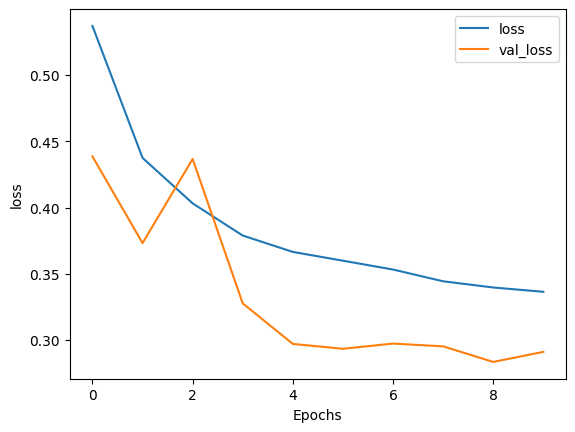

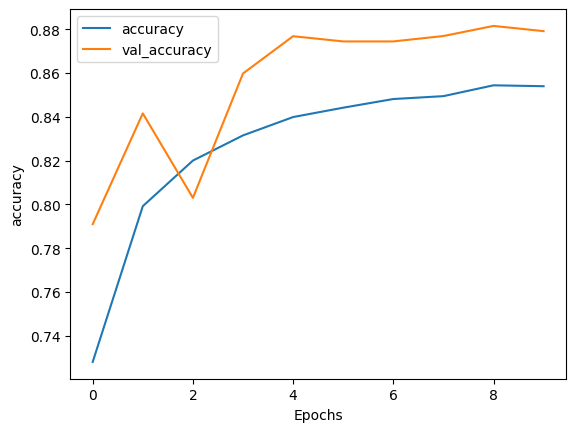

In [18]:
from utils.plot_utils import plot_history_metrics
plot_history_metrics(history, ['loss', 'accuracy'])